UTILS FUNCTIONS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_histo(df: pd.DataFrame | pd.Series, title: str, ylabel: str, xlabel: str = 'Date'):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)
    plt.figure(figsize=(14, 6))
    plt.plot(df, label=df.columns)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_heatmap(df: pd.DataFrame, title: str, ylabel: str, xlabel: str):
    size = int(len(df) * 2/3)
    plt.figure(figsize=(size, size-2))
    sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=df.columns,  # shock from
        yticklabels=df.columns,  # affected variable
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

DATA FETCHING & CLEANING

In [3]:
import yfinance as yf

In [4]:
# Download params
START_DATE_OBS = "2006-01-01"
END_DATE_OBS = "2019-06-30"
END_DATE_BACKTESTING = "2023-12-31"
TICKERS = [
    "ZT=F",
    "ZS=F",
    "ZR=F",
    "ZO=F",
    "ZN=F",
    "ZM=F",
    "ZL=F",
    "ZF=F",
    # "ZC=F" Issue with covariance matrix (all values at 0) # Corn Future
    "ZB=F",
    "YM=F",
    "SIL=F",
    # "SI=F", # No data available in 2006 # Silver Future 
    "SB=F",
    # "RTY=F", # No data available in 2006 # Russel 2000 index Future
    "RB=F",
    "PL=F",
    # "PA=F", # No data available in 2006 # Palladium Future
    "OJ=F",
    "NQ=F",
    "NG=F",
    # "MGC=F", # No data available in 2006 # Micro gold Future
    # "LE=F", # No data available in 2006 # Livestock Future
    "LBS=F",
    "KE=F",
    "KC=F",
    "HO=F",
    "HG=F",
    "HE=F",
    "GF=F",
    "GC=F",
    "ES=F",
    "CT=F",
    "CL=F",
    "CC=F",
    # "BZ=F", # No data available in 2006 # Brent Crude Oil Future
    # "B0=F", # not found # Mont Belvieu Propane Future
] # List of all commodities availables on YahooFinance the 04/06/2025

# Download financial data
df = yf.download(TICKERS, start=START_DATE_OBS, end=END_DATE_BACKTESTING, group_by="tickers", auto_adjust=True)

[*********************100%***********************]  29 of 29 completed


In [5]:
# Data cleaning
MISSING_THRESHOLD = 0.05

inconsistent_tickers = [
    ticker
    for ticker in df.columns.levels[0]
    if ("Close" in df[ticker].columns and df[(ticker, "Close")].isna().mean() > MISSING_THRESHOLD)
]
print(f"Dropping tickers: {inconsistent_tickers} due to missing value above threshold of {MISSING_THRESHOLD:.0%}")
data = df.drop(columns=inconsistent_tickers, level=0)  # dropping tickers
data = data.bfill()  # backfilling

close = data.xs("Close", axis=1, level=1)

print(f"Tickers: {list(close.columns)}")

Dropping tickers: ['PL=F', 'SIL=F'] due to missing value above threshold of 5%
Tickers: ['ZO=F', 'ZB=F', 'KC=F', 'ZM=F', 'GC=F', 'NG=F', 'RB=F', 'ZL=F', 'CL=F', 'ZF=F', 'HG=F', 'CT=F', 'YM=F', 'ZT=F', 'ZS=F', 'LBS=F', 'ES=F', 'NQ=F', 'ZN=F', 'SB=F', 'CC=F', 'KE=F', 'OJ=F', 'HE=F', 'GF=F', 'ZR=F', 'HO=F']


In [ ]:
# close.to_csv('data.csv') # Decommenter pour exporter les données

DYIC

In [6]:
import warnings
from statsmodels.tsa.api import VAR
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.vector_ar.var_model import VARResultsWrapper

In [7]:
def roll(df: pd.DataFrame, window_size: int):
    """
    Generates rolling windows of a DataFrame.
    Yields:
    -------
    pd.DataFrame
        A rolling window of the DataFrame.
    """
    for i in range(len(df) - window_size):
        yield df.iloc[i : i + window_size]

def generalized_fevd(var_results: "VARResultsWrapper", horizon: int):
    """
    Compute the Generalized Forecast Error Variance Decomposition (GFEVD)
    for a fitted VAR model, as described by Diebold and Yilmaz. Implementation made by chatpgt and gemini

    Returns:
    --------
    gfevd_matrix: np.ndarray
        N x N matrix where element (i,j) is the contribution of shock j
        to the forecast error variance of variable i.
    """
    sigma_u = var_results.sigma_u  # Residual covariance matrix, shape (N, N)
    if isinstance(sigma_u, pd.DataFrame):
        sigma_u = sigma_u.values

    var_coeffs = var_results.coefs  # VAR coefficient matrices, shape (lag, N, N)
    p_lags, N, _ = var_coeffs.shape

    # Compute MA coefficient matrices A_h for h=0,...,H-1
    ma_coeffs = np.zeros((horizon, N, N))
    ma_coeffs[0] = np.eye(N)
    for h in range(1, horizon):
        for k in range(1, p_lags + 1):
            if h - k >= 0:
                ma_coeffs[h] += np.dot(var_coeffs[k - 1], ma_coeffs[h - k])

    # Calculate GFEVD (theta_ij elements before normalization)
    gfevd_unnormalized = np.zeros((N, N))

    # Calculate denominators
    denominators = np.zeros(N)
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        for h in range(horizon):  # Sum from h=0 to H-1
            term = np.dot(ma_coeffs[h], np.dot(sigma_u, ma_coeffs[h].T))
            denominators[i] += np.dot(e_i.T, np.dot(term, e_i))

    # Calculate each element (i,j) of the GFEVD matrix
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        for j in range(N):
            e_j = np.zeros(N)
            e_j[j] = 1.0

            sigma_jj_inv = 1.0 / sigma_u[j, j]
            if np.isinf(sigma_jj_inv) or np.isnan(sigma_jj_inv):  # Handle potential division by zero if sigma_jj is 0
                print(
                    f"Warning: sigma_jj for variable {j} is zero or very small. Setting sigma_jj_inv to a large number."
                )
                sigma_jj_inv = 1e12  # A large number to avoid NaN, but indicates an issue

            numerator_sum_sq = 0.0
            for h in range(horizon):
                val = np.dot(e_i.T, np.dot(ma_coeffs[h], np.dot(sigma_u, e_j)))
                numerator_sum_sq += val**2

            if denominators[i] == 0:
                # This implies the forecast error variance of variable i is zero, problematic.
                print(f"Warning: Denominator for GFEVD for variable {i} is zero. Setting GFEVD contribution to 0.")
                gfevd_unnormalized[i, j] = 0.0
            else:
                gfevd_unnormalized[i, j] = (sigma_jj_inv * numerator_sum_sq) / denominators[i]

    # Normalize rows to sum to 1 to get the Pairwise Connectedness Matrix C^H_{i <- j}
    row_sums = gfevd_unnormalized.sum(axis=1, keepdims=True)
    # Handle cases where a row sum is zero (e.g., if a variable has zero forecast error variance)
    safe_row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace 0 with 1 to avoid NaN, result will be 0.
    gfevd_normalized = gfevd_unnormalized / safe_row_sums
    gfevd_normalized = np.where(row_sums == 0, 0, gfevd_normalized)  # Ensure original zero rows are zero

    return gfevd_normalized

def get_dyci(
    returns: pd.DataFrame, rolling_window: int, forecast_horizon: int, max_lag: int
) -> tuple[pd.Series, np.ndarray]:
    tci = []  # Total Connectedness Index values
    gfevd_matrices = []  # GFEVD matrices for each window

    # Iterate through rolling windows
    counter = 0
    for window_data in roll(returns, rolling_window):
        model = VAR(window_data)
        results = model.fit(maxlags=max_lag)

        # Calculate Generalized Forecast Error Variance Decomposition (GFEVD)
        gfevd_matrix = generalized_fevd(results, forecast_horizon)
        gfevd_matrices.append(gfevd_matrix)

        # Calculate Total Connectedness Index (TCI)
        total_connectedness = 100 * (1 - np.trace(gfevd_matrix) / len(returns.columns))
        tci.append(total_connectedness)
        if counter % 200 == 0:
            print(f"Lag {counter} completed in DYCI ({counter / len(returns):.2%})")
        counter += 1

    # Create a pandas Series for the TCI for easier plotting
    tci_series = pd.Series(tci, index=returns.index[rolling_window : rolling_window + len(tci)], name='TCI')
    return tci_series, np.array(gfevd_matrices)

In [8]:
## Parameters for DYIC as per https://financialconnectedness.org/info_stock.html
ROLLING_WINDOW = 150
FORECAST_HORIZON = 10
MAX_LAG = 3

# Remove model VAR Warning -> ValueWarning: No frequency information was provided, so inferred frequency B will be used.
warnings.filterwarnings("ignore", category=ValueWarning)

returns = np.log(close / close.shift()).dropna()

close_obs = close.loc[:END_DATE_OBS]
returns_obs = returns.loc[:END_DATE_OBS]

tci_series, gfevd_matrices = get_dyci(returns_obs, ROLLING_WINDOW, FORECAST_HORIZON, MAX_LAG)


c:\Users\etien\OneDrive - Groupe ESSCA\Windows\Dev\ConnectednessPortfolio\.venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Lag 0 completed in DYCI (0.00%)
Lag 200 completed in DYCI (5.88%)
Lag 400 completed in DYCI (11.76%)
Lag 600 completed in DYCI (17.64%)
Lag 800 completed in DYCI (23.52%)
Lag 1000 completed in DYCI (29.40%)
Lag 1200 completed in DYCI (35.28%)
Lag 1400 completed in DYCI (41.16%)
Lag 1600 completed in DYCI (47.04%)
Lag 1800 completed in DYCI (52.93%)
Lag 2000 completed in DYCI (58.81%)
Lag 2200 completed in DYCI (64.69%)
Lag 2400 completed in DYCI (70.57%)
Lag 2600 completed in DYCI (76.45%)
Lag 2800 completed in DYCI (82.33%)
Lag 3000 completed in DYCI (88.21%)
Lag 3200 completed in DYCI (94.09%)


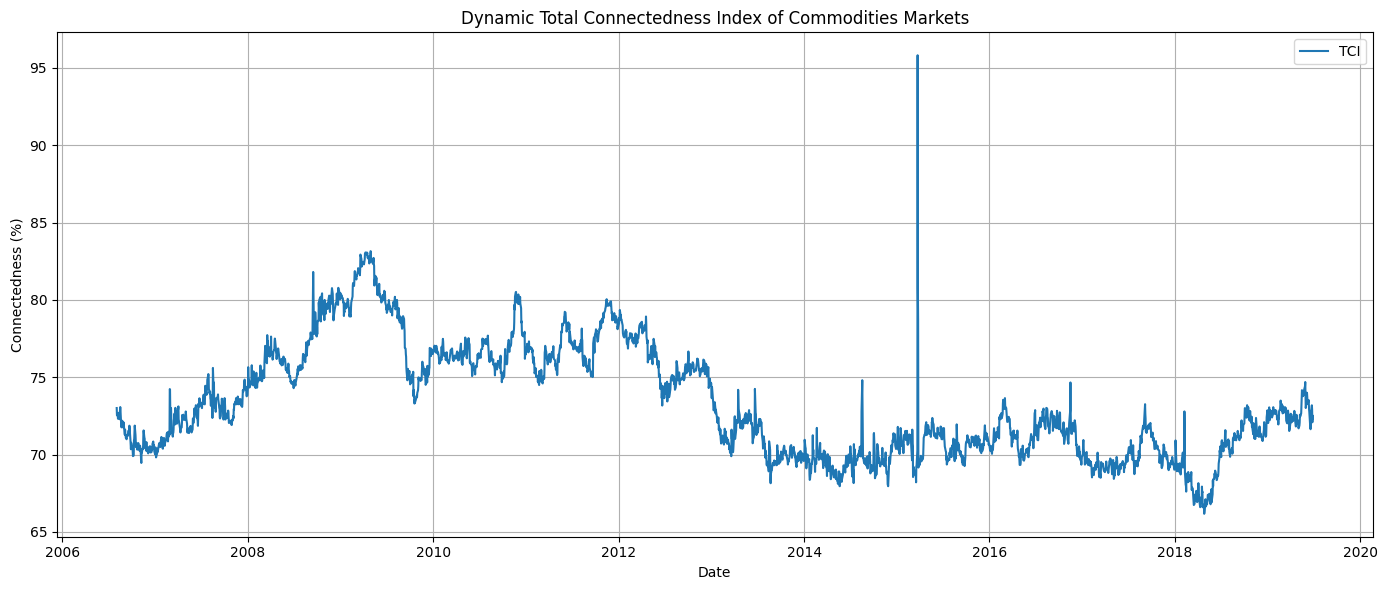

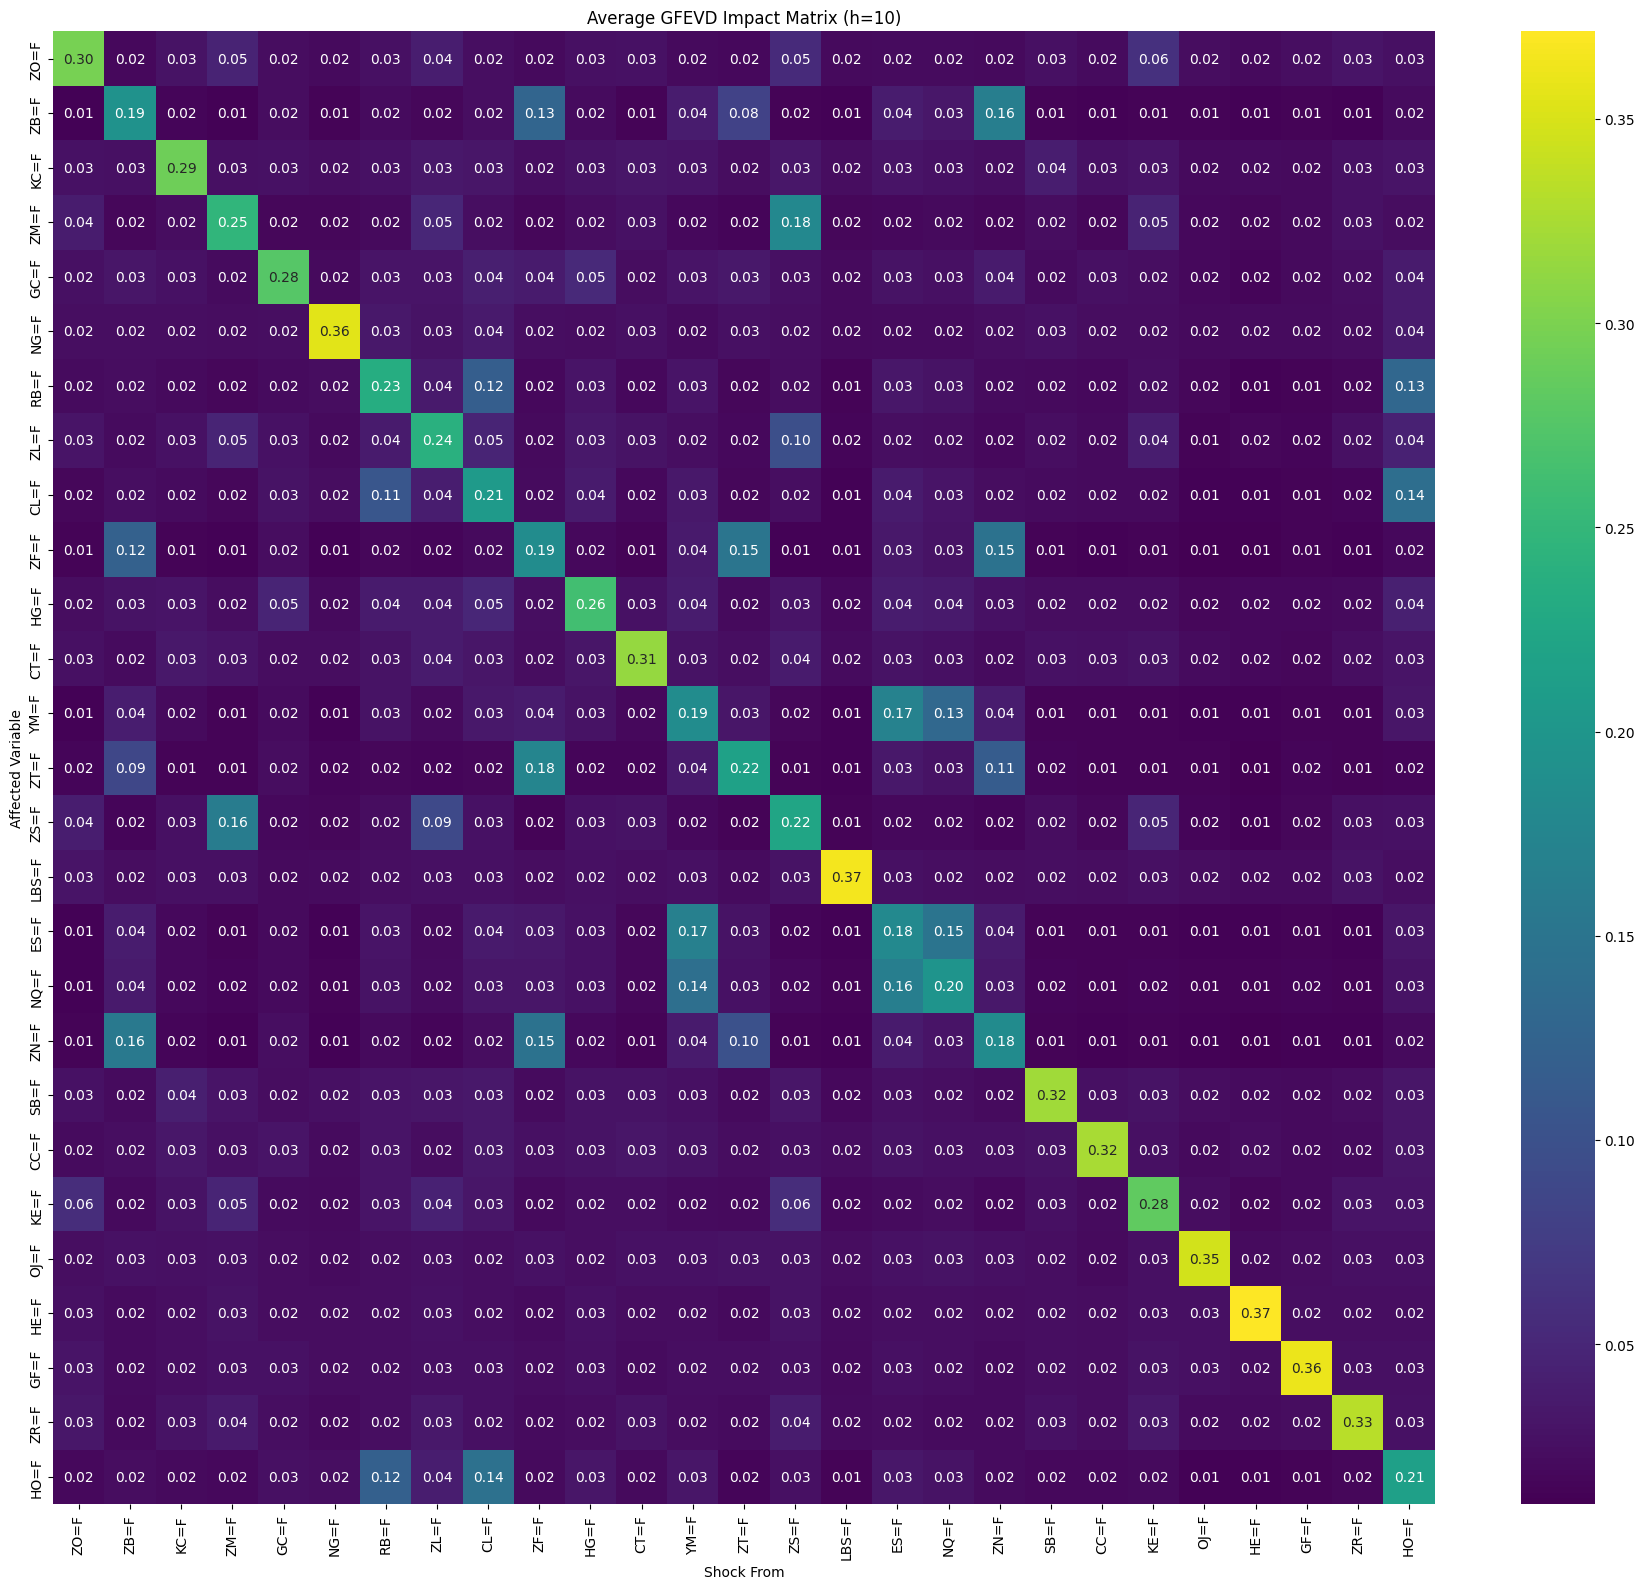

In [9]:
gfevd_avg = pd.DataFrame(np.mean(gfevd_matrices, axis=0), index=close_obs.columns, columns=close_obs.columns)

plot_histo(tci_series, title='Dynamic Total Connectedness Index of Commodities Markets', ylabel='Connectedness (%)')
plot_heatmap(gfevd_avg, title=f"Average GFEVD Impact Matrix (h={FORECAST_HORIZON})", ylabel="Affected Variable", xlabel="Shock From")

PORTFOLIO OPTIMIZATION

In [10]:
WEIGHT_BONDS =(0, 0.3)

PORTFOLIO OPTIMIZATION USING AVERAGE DYIC

In [11]:
from pypfopt import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return

In [12]:
mu = mean_historical_return(close_obs)

ef = EfficientFrontier(mu, gfevd_avg, weight_bounds=WEIGHT_BONDS)
w = ef.max_sharpe()

w_ptf_dyic_avg = pd.Series({ticker: w for ticker, w in w.items() if w > 0}, name='dyic_opt_w_avg')
w_ptf_dyic_avg

ZO=F    0.030910
ZB=F    0.045937
ZM=F    0.107090
GC=F    0.230886
YM=F    0.126873
NQ=F    0.300000
CC=F    0.084687
HE=F    0.006558
GF=F    0.016744
ZR=F    0.050314
Name: dyic_opt_w_avg, dtype: float64

PORTFOLIO OPTIMIZATION USING COVARIANCE MATRIX

In [13]:
from pypfopt.risk_models import risk_matrix

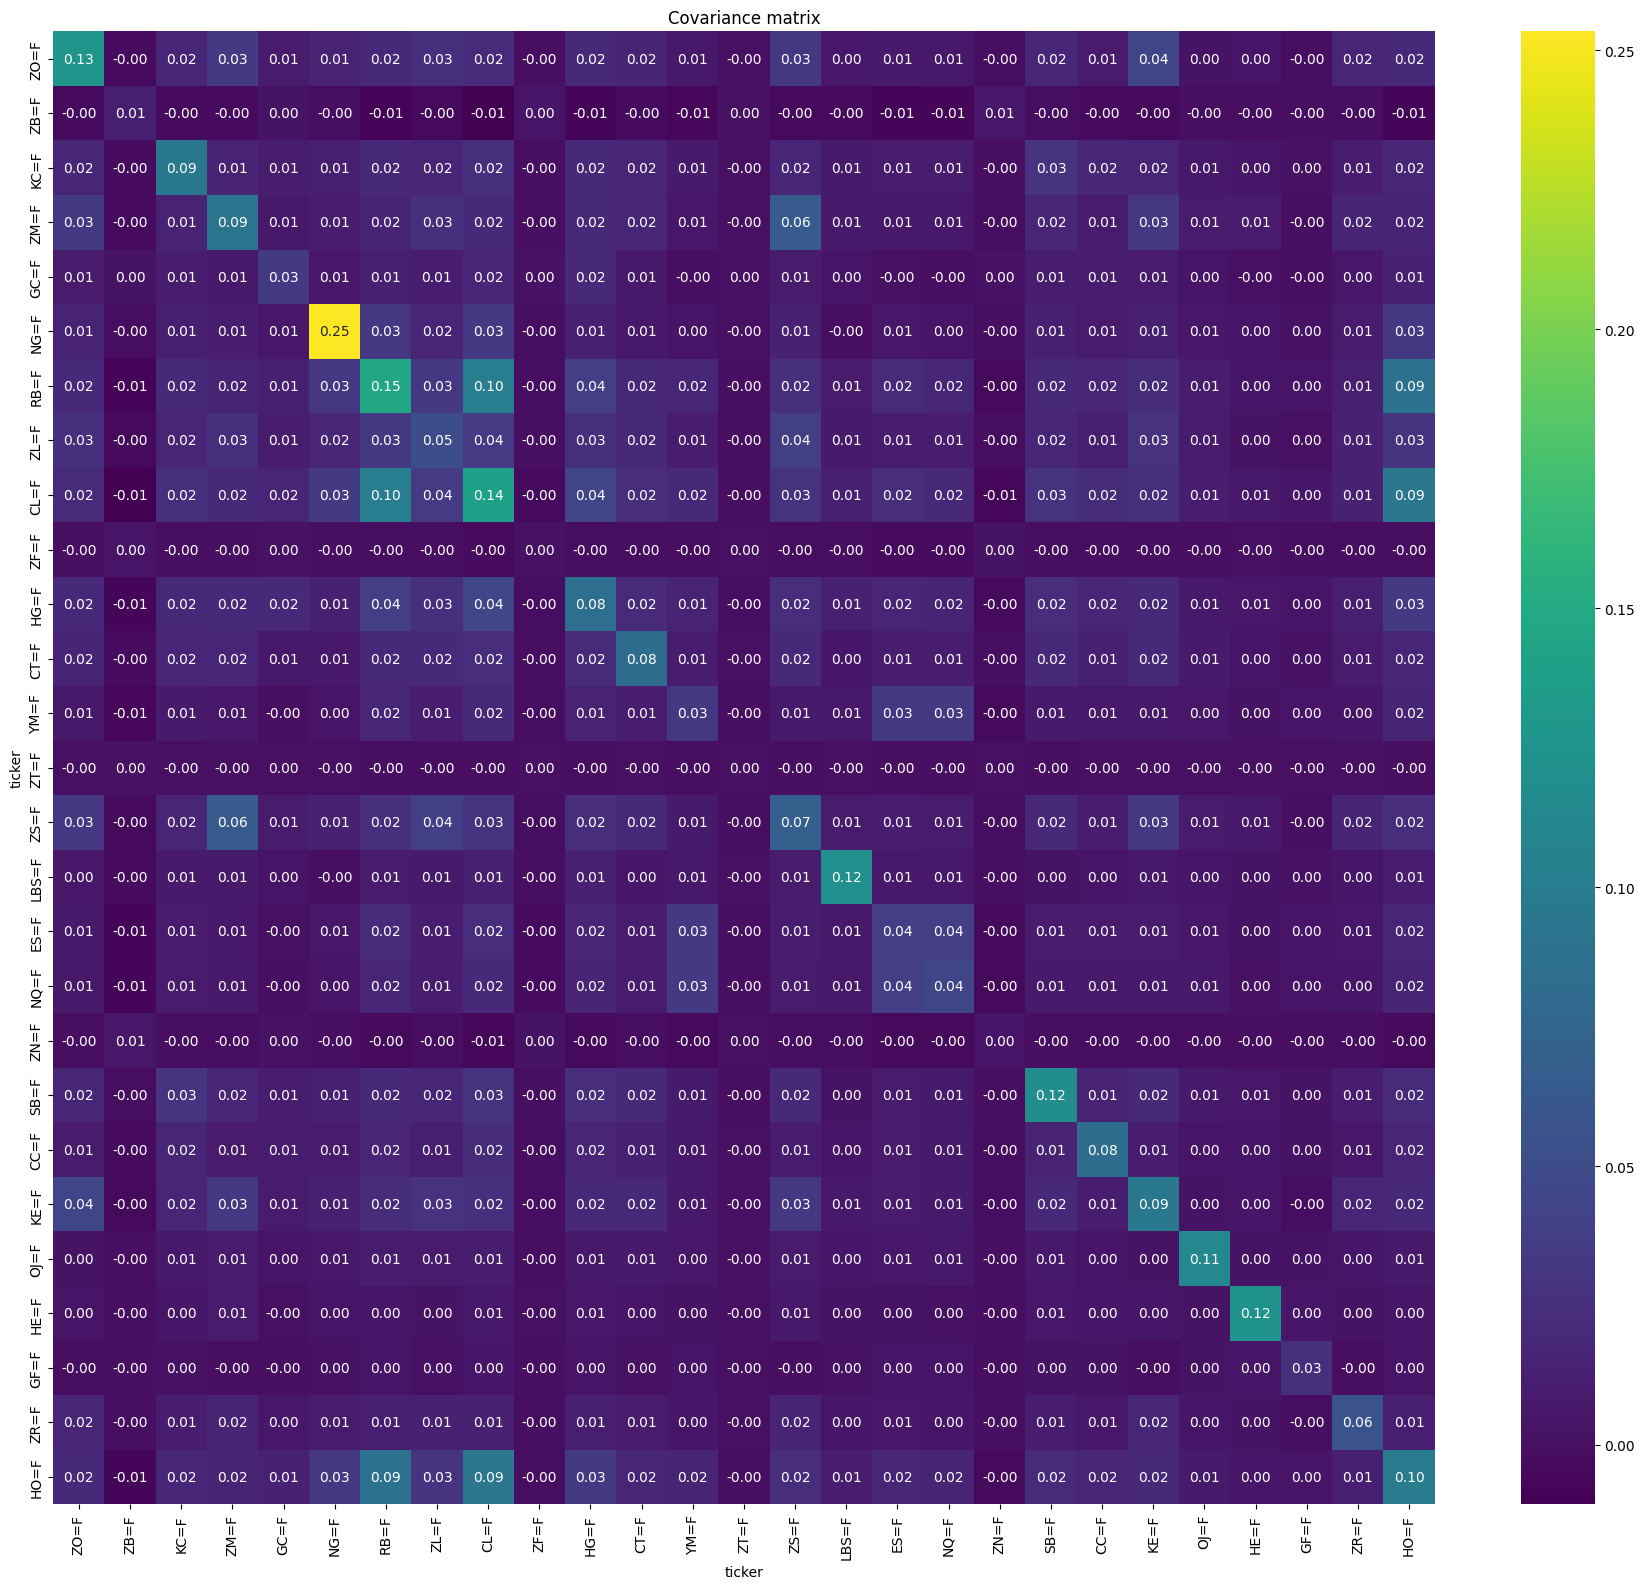

In [14]:
cov_matrix = risk_matrix(close_obs)
plot_heatmap(cov_matrix, title='Covariance matrix', ylabel='ticker', xlabel='ticker')

In [ ]:
ef = EfficientFrontier(mu, cov_matrix, weight_bounds=WEIGHT_BONDS)
w = ef.max_sharpe()

w_ptf_cov = pd.Series({ticker: w for ticker, w in w.items() if w > 0.001}, name='covariance_matrix_opt_w')  # Removing e-16 values 
w_ptf_cov

ZB=F    0.137059
ZM=F    0.005527
GC=F    0.107757
ZF=F    0.230374
ZT=F    0.300000
NQ=F    0.193514
HE=F    0.001769
GF=F    0.019110
ZR=F    0.004889
Name: covariance_marix_opt_w, dtype: float64

PORTFOLIO OPTIMIZATION USING crisis-focus DYIC

In [16]:
returns_crisis = returns.loc["2008-06-01":"2009-10-31"]
_, gfevd_matrices_crisis = get_dyci(returns_crisis, ROLLING_WINDOW, FORECAST_HORIZON, MAX_LAG)

Lag 0 completed in DYCI (0.00%)
Lag 200 completed in DYCI (55.71%)


In [17]:
gfevd_crisis = pd.DataFrame(np.mean(gfevd_matrices_crisis, axis=0), index=returns_crisis.columns, columns=returns_crisis.columns)

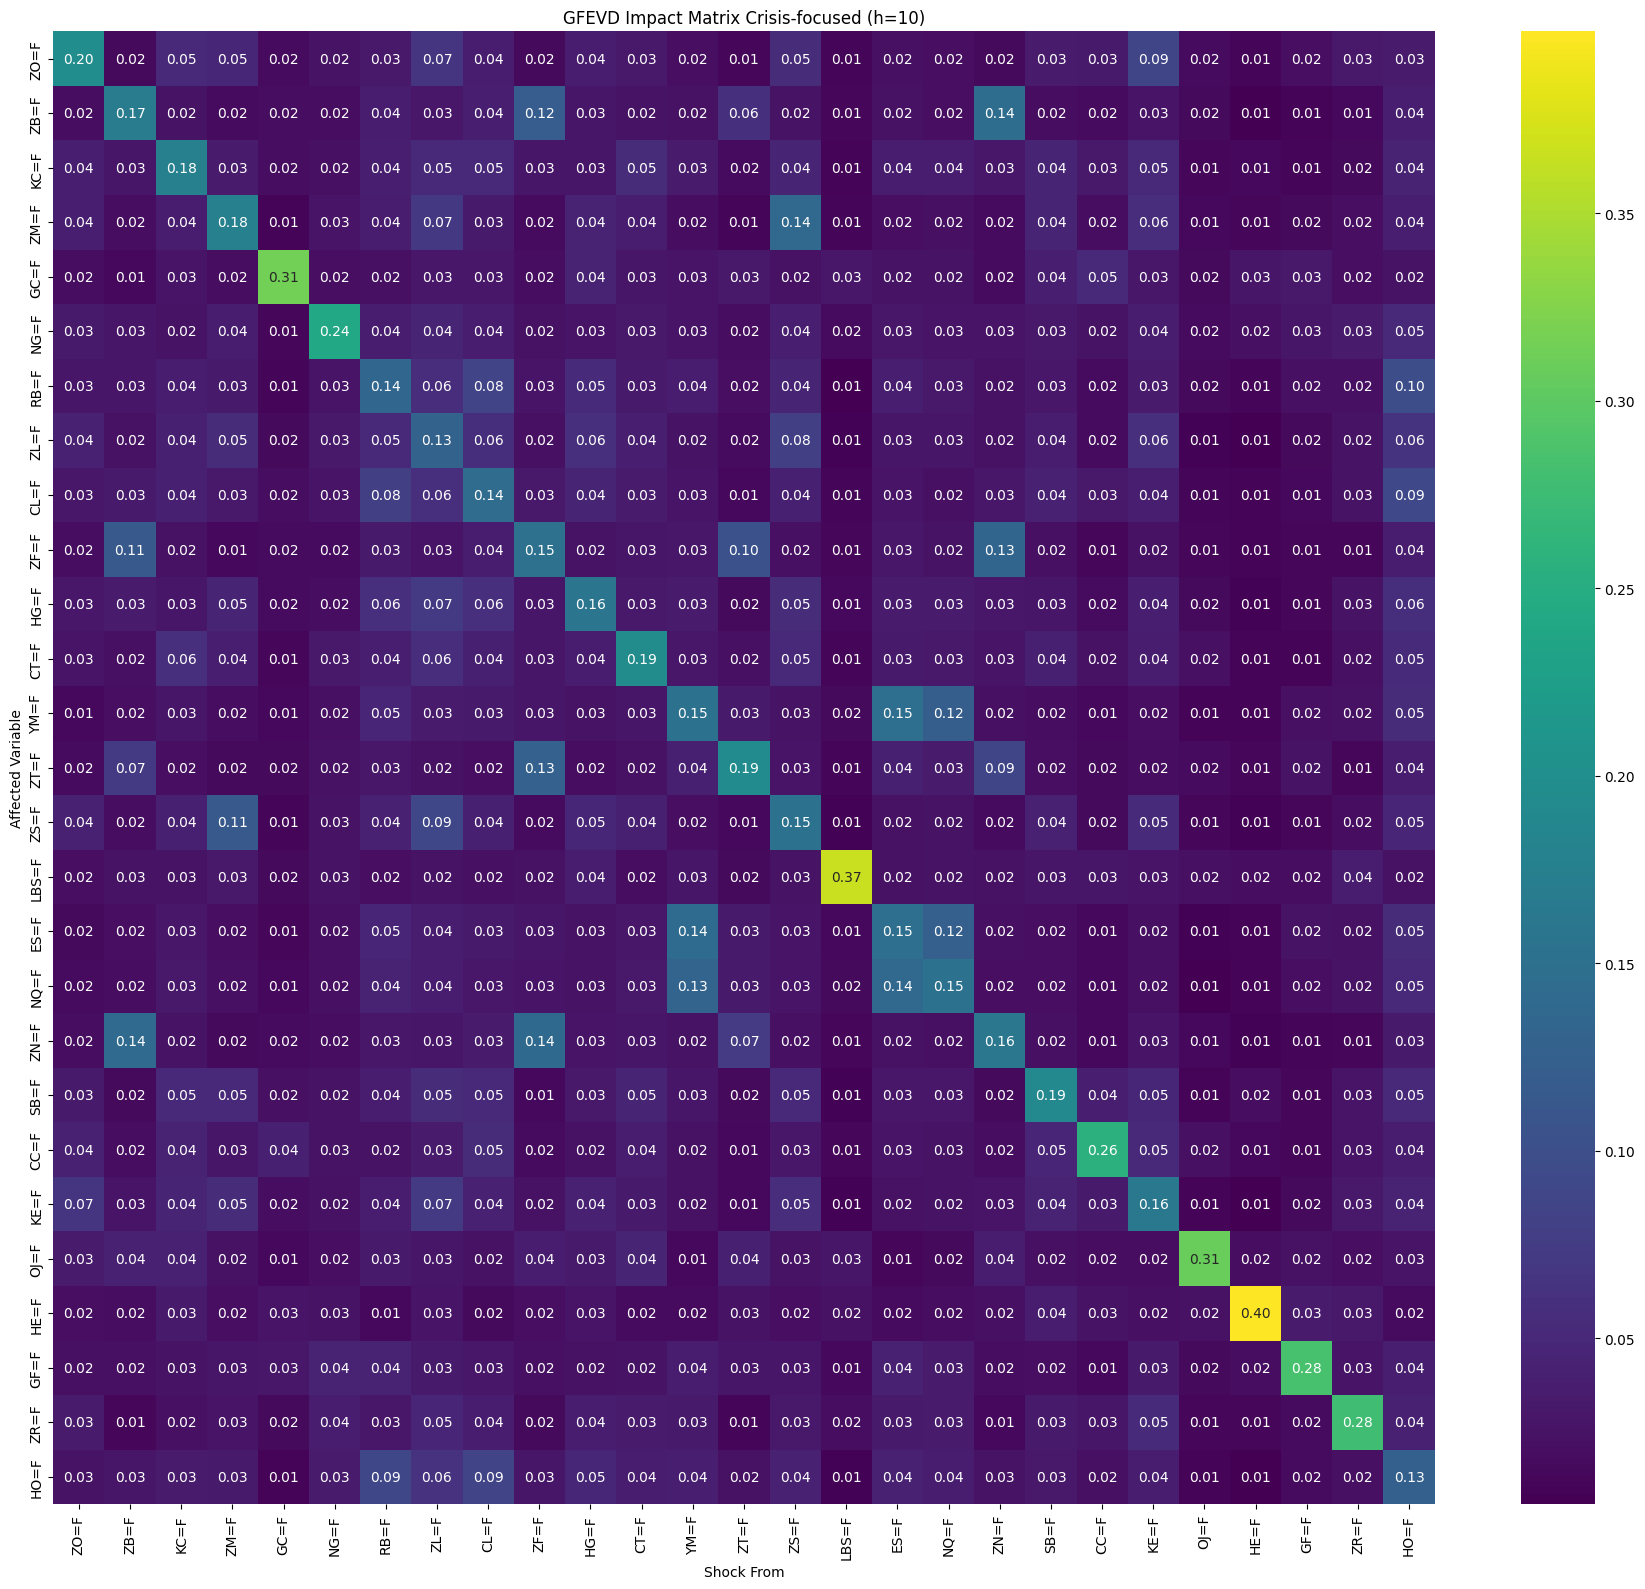

In [18]:
plot_heatmap(gfevd_crisis, title=f"GFEVD Impact Matrix Crisis-focused (h={FORECAST_HORIZON})", ylabel="Affected Variable", xlabel="Shock From")

In [19]:
mu = mean_historical_return(close_obs)

ef = EfficientFrontier(mu, gfevd_crisis, weight_bounds=WEIGHT_BONDS)
w = ef.max_sharpe()

w_ptf_dyic_crisis = pd.Series({ticker: w for ticker, w in w.items() if w > 0}, name='dyic_opt_w_crisis')
w_ptf_dyic_crisis

ZO=F    0.037301
ZB=F    0.079273
ZM=F    0.136937
GC=F    0.177006
YM=F    0.137166
NQ=F    0.300000
CC=F    0.075722
HE=F    0.010116
GF=F    0.006738
ZR=F    0.039741
Name: dyic_opt_w_crisis, dtype: float64

MODEL COMPARISON

In [20]:
ptf_cov_returns = returns.loc[END_DATE_OBS:, w_ptf_cov.keys()] @ w_ptf_cov
ptf_dyic_avg_returns = returns.loc[END_DATE_OBS:, w_ptf_dyic_avg.keys()] @ w_ptf_dyic_avg
ptf_equi_returns = returns.loc[END_DATE_OBS:] @ np.ones(len(returns.columns)) / len(returns.columns)
ptf_dyic_crisis_returns = returns.loc[END_DATE_OBS:, w_ptf_dyic_crisis.keys()] @ w_ptf_dyic_crisis

ptf_cov_returns.name = 'covariance'
ptf_dyic_avg_returns.name =  'dyic_avg'
ptf_dyic_crisis_returns.name =  'dyic_crisis'
ptf_equi_returns.name =  'equi_weighted'

In [21]:
ptf_cov_val = np.exp(np.cumsum(ptf_cov_returns))
ptf_dyic_avg_val = np.exp(np.cumsum(ptf_dyic_avg_returns))
ptf_dyic_crisis_val = np.exp(np.cumsum(ptf_dyic_crisis_returns))
ptf_equi_val = np.exp(np.cumsum(ptf_equi_returns))

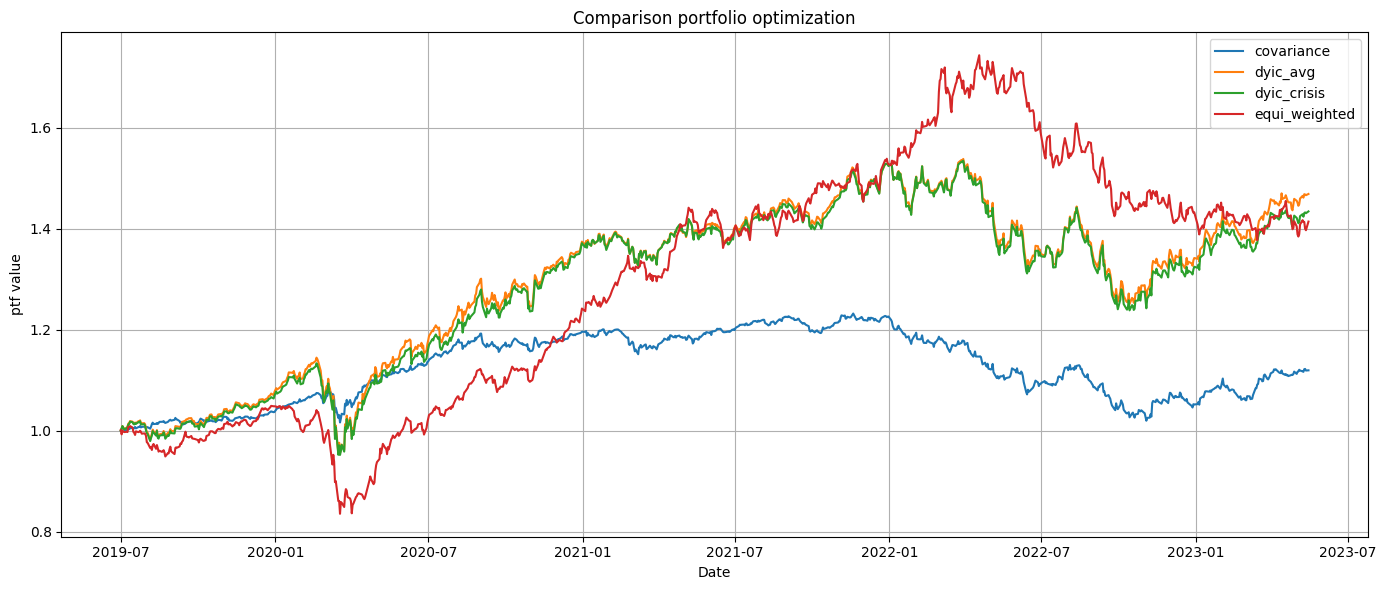

In [22]:
ptf_values = pd.concat([ptf_cov_val, ptf_dyic_avg_val, ptf_dyic_crisis_val, ptf_equi_val], axis=1)

plot_histo(ptf_values, 'Comparison portfolio optimization', 'ptf value')

In [23]:
ptf_values.describe()

,covariance,dyic_avg,dyic_crisis,equi_weighted
count,974.000000,974.000000,974.000000,974.000000
mean,1.124551,1.299947,1.290457,1.300404
std,0.067888,0.158390,0.158052,0.240466
min,1.000143,0.955007,0.952165,0.835588
25%,1.064188,1.170757,1.154695,1.043063
50%,1.123376,1.351127,1.345930,1.396771
75%,1.184563,1.417294,1.406433,1.471780
max,1.232159,1.538345,1.534789,1.743609


In [24]:
ptf_values["2020-01-01":"2020-06-30"].describe()

,covariance,dyic_avg,dyic_crisis,equi_weighted
count,123.000000,123.000000,123.000000,123.000000
mean,1.081382,1.101419,1.089866,0.970429
std,0.031213,0.055459,0.052043,0.063762
min,1.016474,0.955007,0.952165,0.835588
25%,1.055793,1.078788,1.068956,0.914413
50%,1.072353,1.111170,1.099712,0.995981
75%,1.111360,1.137764,1.124955,1.017608
max,1.136167,1.181075,1.163535,1.049140
